# Notebook to quickly look at odor response (or lack thereof)

## Imports

In [1]:
import os 
import pickle

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from mosquito.process_abf import load_processed_data

## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


In [3]:
# current color cycle
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


['#8dd3c7', '#feffb3', '#bfbbd9', '#fa8174', '#81b1d2', '#fdb462', '#b3de69', '#bc82bd', '#ccebc4', '#ffed6f']


## Load data

In [4]:
# paths to data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '22_20240516' # 
axo_num =  12
# vid_str = 'aedes_C001H001S0001_20240326_154951'

data = load_processed_data(data_folder, axo_num)

In [5]:
# read out some data
t = data['time']
emg_filt = data['emg_filt'] 
try:
    odor = data['odor']
except KeyError:
    odor = np.zeros(emg_filt.shape, dtype=bool)
    
spike_rate = data['spike_rate']
fs = data['sampling_freq']
wbf = data['wbf'] 
spike_idx = data['spike_idx']

odor = (odor > 2)
odor = odor.astype(float)

## Quick plot of emg and odor signal

(-0.05, 0.1)

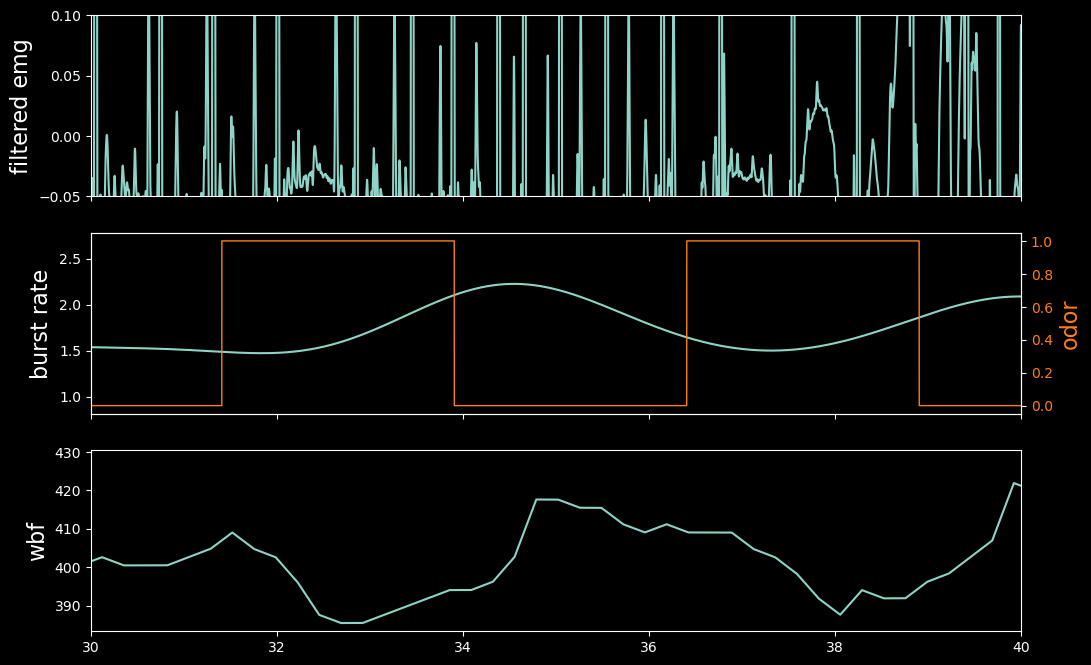

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(12,8))

ax0.plot(t, emg_filt)
ax0.set_ylabel('filtered emg')

ax1.plot(t, spike_rate)
ax1.set_ylabel('burst rate')
# ax1.set_ylabel('filtered emg (V)')

ax11 = ax1.twinx()
color = 'tab:orange'
ax11.plot(t, odor, color=color, lw=1.0)
ax11.tick_params(axis='y', labelcolor=color)
ax11.set_ylabel('odor', color=color) 


ax2.plot(t, wbf)
ax2.set_ylabel('wbf')

ax0.autoscale(enable=True, axis='x', tight=True)
ax0.set_xlim([30, 40])
ax0.set_ylim([-0.05, 0.1])
# ax1.autoscale(enable=True, axis='x', tight=True)


In [8]:
# align stimuli
off_pts = np.where(np.diff(odor) < -0.5)[0]
# off_pts = np.insert(off_pts, 0, 0)
off_pts

array([ 137279,  312679,  488080, ..., 3820694, 3996095, 4171496])

(0.0, 9.999971499415738)

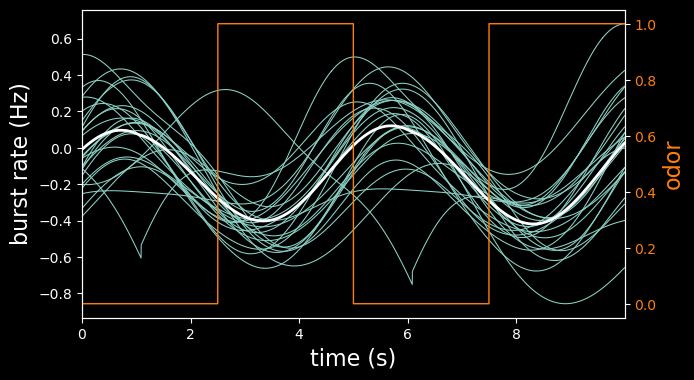

In [9]:
# plot aligned stimuli
fig, ax = plt.subplots(figsize=(7,4))

data_list = []

for ith in range(len(off_pts)):
    idx_curr = np.arange(off_pts[ith] - 10*fs , off_pts[ith])
    t_curr = (1/fs)*(idx_curr - idx_curr[0])
    odor_curr = odor[idx_curr]
    spike_rate_curr = spike_rate[idx_curr] - np.mean(spike_rate[idx_curr][odor_curr < 0.5])
    data_list.append(spike_rate_curr)
    
    ax.plot(t_curr,  spike_rate_curr, '-', color='#8dd3c7', lw=0.75)

data_mat = np.vstack(data_list)
ax.plot(t_curr,  np.mean(data_mat, axis=0), '-', color='w', lw=2.0)

# set left axis props
ax.set_ylabel('burst rate (Hz)')
ax.set_xlabel('time (s)')

# plto odor stimulus on top
ax_odor = ax.twinx()
color = 'tab:orange'
ax_odor.plot(t_curr, odor[idx_curr], color=color, lw=1.0)
ax_odor.tick_params(axis='y', labelcolor=color)
ax_odor.set_ylabel('odor', color=color) 

ax.set_xlim([t_curr[0], t_curr[-1]])

(0.0, 9.999971499415738)

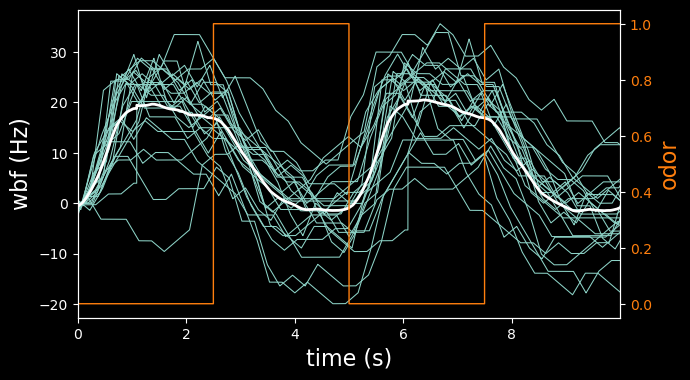

In [10]:
# plot aligned stimuli
fig, ax = plt.subplots(figsize=(7,4))

wbf_data_list = []

for ith in range(len(off_pts)):
    idx_curr = np.arange(off_pts[ith] - 10*fs , off_pts[ith])
    t_curr = (1/fs)*(idx_curr - idx_curr[0])
    odor_curr = odor[idx_curr]
    wbf_curr = wbf[idx_curr] 
    wbf_curr -= np.mean(wbf_curr[:5000])
    wbf_data_list.append(wbf_curr)
    
    ax.plot(t_curr,  wbf_curr, '-', color='#8dd3c7', lw=0.75)

wbf_data_mat = np.vstack(wbf_data_list)
ax.plot(t_curr,  np.mean(wbf_data_mat, axis=0), '-', color='w', lw=2.0)

# set left axis props
ax.set_ylabel('wbf (Hz)')
ax.set_xlabel('time (s)')

# plto odor stimulus on top
ax_odor = ax.twinx()
color = 'tab:orange'
ax_odor.plot(t_curr, odor[idx_curr], color=color, lw=1.0)
ax_odor.tick_params(axis='y', labelcolor=color)
ax_odor.set_ylabel('odor', color=color) 

ax.set_xlim([t_curr[0], t_curr[-1]])

Text(0, 0.5, 'burst rate (Hz)')

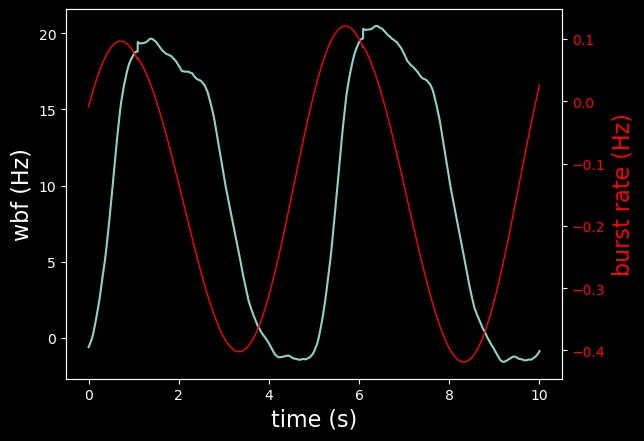

In [11]:
# plot means of wbf and burst rate
fig, ax0 = plt.subplots()

wbf_mean = np.mean(wbf_data_mat, axis=0)
wbf_t = (1/fs)*np.arange(wbf_mean.size)
ax0.plot(wbf_t, wbf_mean)

ax0.set_ylabel('wbf (Hz)')
ax0.set_xlabel('time (s)')

# plto odor stimulus on top
ax1 = ax0.twinx()
color = 'r'
burst_rate_mean = np.mean(data_mat, axis=0)
burst_rate_t = (1/fs)*np.arange(burst_rate_mean.size)
ax1.plot(burst_rate_t, burst_rate_mean, color=color, lw=1.0)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('burst rate (Hz)', color=color) 

In [ ]:
# # check that phase offset between wbf and burst rate isn't just a convolution artifact
# fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,6), sharex=True)

# tmin = 0 
# tmax = 20
# mask = (t >= tmin) & (t <= tmax)

# ax0.plot(t[mask], wbf[mask])
# ax0.set_ylabel('wbf (Hz)')

# for idx in spike_idx:
#     ax1.axvline(t[idx], color='w', lw=0.55)
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('bursts')

# ax0.set_xlim([tmin, tmax])
# ax1.set_xlim([tmin, tmax])
# # plt.show()

## Scratch

In [195]:
readme_path = os.path.join(data_root, data_folder, 'README.txt')
if os.path.exists(readme_path):
    readme_dict = dict()
    with open(readme_path) as f:
        # readme = f.read()
        for line in f:
            if line.strip():
                line_text = line.rstrip()
                print(line_text)
                key = line_text.split(':')[0]
                item = line_text.split(':')[1]
                readme_dict[key] = item
          
readme_dict

Date: 05/08/24
Species: Drosophila melanogaster (HCS+)
Eclosion date: unknown
Amplifier: AM 1800 (AC)
Odor stimulus type: None
Odor stimulus flow rate: N/A
HPA flow rate: N/A


{'Date': ' 05/08/24',
 'Species': ' Drosophila melanogaster (HCS+)',
 'Eclosion date': ' unknown',
 'Amplifier': ' AM 1800 (AC)',
 'Odor stimulus type': ' None',
 'Odor stimulus flow rate': ' N/A',
 'HPA flow rate': ' N/A'}

In [197]:
species_entry = readme_dict['Species']
drosophila_keywords = ["drosophila", "melanogaster", "hcs+"]

if any(keyword in species_entry for keyword in drosophila_keywords):
    print('fruit fly')

fruit fly
